In [1]:
from nbwrapper import getargs
from pprint import pprint
from multiprocessing import Pool, Value

import re
import numpy as np
import pickle
from itertools import repeat, count, product, chain
import sys
import pysam
from math import floor
import os.path

import seaborn as sns
import pandas
from pylab import * 
from itertools import product as iterproduct, groupby, chain, permutations, repeat
%matplotlib inline

%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/alignment_lib.ipynb"
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/analysis_lib.ipynb"

In [2]:
args = getargs()

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/nbwrapper.py:31: RuntimeWarning: no arguments passed!
  warnings.warn("no arguments passed!", RuntimeWarning)


In [3]:
## for testing only
# args = {
#     "events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_events.2D.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/david_eccles_bc_ideas/mouse_ref.fa",
#     "out_basename": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment",
#     "ncores": 24,
#     "nmer": 5
# }

# args = {
#     "events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_events.2D.62pA.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
#     "out_basename": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment.62pA",
#     "ncores": 62
# }

args = {
    "events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_100.events.2D.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/LomanLab_MAP-006/ecoli_mg1655.fa",
    "out_basename": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_100.alignment",
    "models": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1.model.pickle",
    "ncores": 62,
    "nmer": 6
}

# args = {
#     "events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_5000.events.2D.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/LomanLab_MAP-006/ecoli_mg1655.fa",
#     "out_basename": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_5000.alignment",
#     "ncores": 62,
#     "nmer": 6
# }

In [4]:
NMER = args["nmer"]

In [5]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [6]:
assert os.path.isfile(args["events"])
assert os.path.isfile(args["ref"])
assert args["ncores"]

### Prepare File Data

In [7]:
def correct_read(file_obj, order, col="template.mean"): 
    
    def correct_drift(mean, start): 
        return mean - (start * file_obj["drift_template"])  
    
    def shift():
        file_obj["events"][col] = file_obj["events"][col].map(lambda x: x-file_obj["shift_template"])
    
    def scale(): 
        file_obj["events"][col] = file_obj["events"][col].map(lambda x: x/file_obj["scale_template"])
        
    def drift(): 
        file_obj["events"][col] = [x for x in map(correct_drift, file_obj["events"][col],
                                      file_obj["events"][col])]

    fx = {
        "shift": shift,
        "scale": scale,
        "drift": drift
    }
    for f in order: 
        fx[f]()
    
    return file_obj

In [8]:
def prepare_file_data(args):
    file_obj, order = args
    """normalize events and save generated called_seq (instead of some metrichor magic)"""
    file_obj = correct_read(file_obj, order)
    called_seq = events2seq(file_obj["events"].to_dict("records"))
    file_obj["fastq"] = "\n".join([file_obj["fastq"].split("\n")[0], called_seq])
    return file_obj

In [9]:
def load_data(): 
    file_data = pickle.load(open(args["events"], 'rb'))
    file_data = [f for f in file_data if f is not None]
    return file_data
file_data = load_data()

(50, 100)

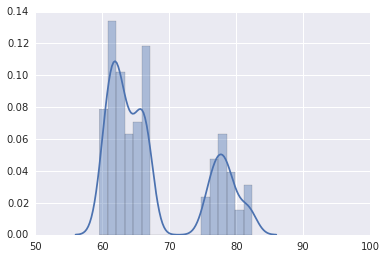

In [10]:
fig, ax = subplots()
sns.distplot([file_obj["events"]["template.mean"].median() for file_obj in file_data for file_obj in file_data], ax=ax)
ax.set_xlim(50, 100)

In [11]:
def apply_correction(file_data, perm): 
    p = Pool(args["ncores"])
    print("Prepare file data: ")
    results = []
    try:
        for i, res in enumerate(p.imap_unordered(prepare_file_data, zip(file_data, repeat(perm))), 1):
            results.append(res)
            sys.stdout.write('\rdone {0:%}'.format(i/float(len(file_data))))
        p.close()
        p.join()
    except KeyboardInterrupt:
        p.terminate()
    return results

(55, 65)

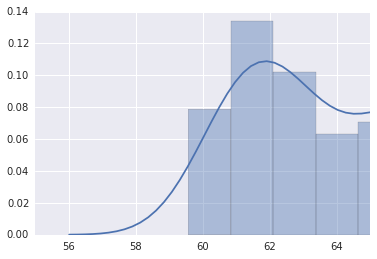

In [12]:
fig, ax = subplots()
sns.distplot([file_obj["events"]["template.mean"].median() for file_obj in file_data for file_obj in file_data], ax=ax)
ax.set_xlim(55, 65)

('shift', 'scale', 'drift')
Prepare file data: 
done 100.000000%std:  0.263944407568
mean:  59.0038973649
('shift', 'drift', 'scale')
Prepare file data: 
done 100.000000%std:  0.263944407568
mean:  59.0038973649
('scale', 'shift', 'drift')
Prepare file data: 
done 100.000000%std:  0.547040417045
mean:  58.707891245
('scale', 'drift', 'shift')
Prepare file data: 
done 100.000000%std:  0.54470956258
mean:  58.7140009202
('drift', 'shift', 'scale')
Prepare file data: 
done 100.000000%std:  0.264807910668
mean:  59.0036526361
('drift', 'scale', 'shift')
Prepare file data: 
done 100.000000%std:  0.54470956258
mean:  58.7140009202


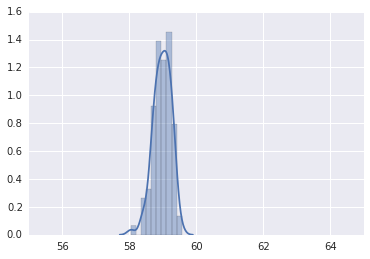

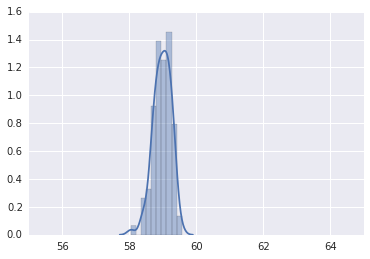

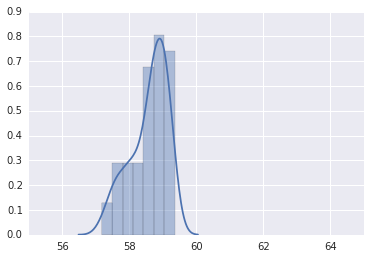

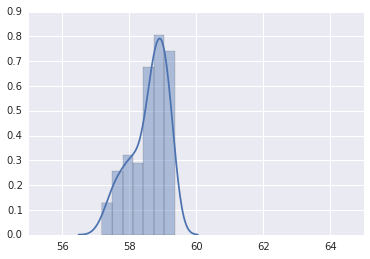

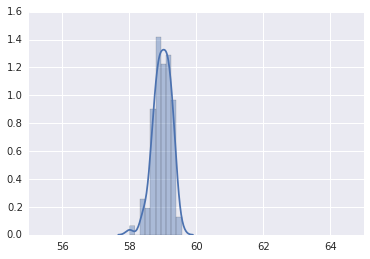

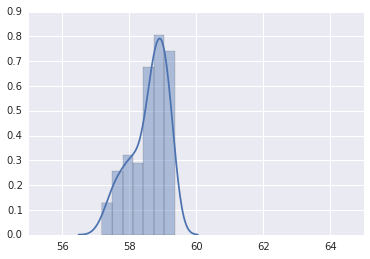

In [13]:
for perm in permutations(["shift", "scale", "drift"]):
    print(perm)
    file_data = apply_correction(load_data(), perm)
#     print(file_data)
    media = [file_obj["events"]["template.mean"].median() for file_obj in file_data]
    print("std: ", np.std(media))
    print("mean: ", np.median(media))
    fig, ax = subplots()
    sns.distplot([file_obj["events"]["template.mean"].median() for file_obj in file_data], ax=ax)
    ax.set_xlim(55, 65)
    draw()